# Plant seedlings classification

**Authors** : Julien Bastian, Walid Ghalleb, Ugo Zennaro 

We consider here the kaggle competition : https://www.kaggle.com/competitions/dhu-ailab-image-classification/, in which the point is to classify plant seedlings. For this we developped a Convolutional Neural Network (CNN) architecture.

### Plan
1. Data preparation
2. Models definition
3. Models training and performance analysis

## Data Preparation

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
import os
os.chdir("C:/Users/julie/OneDrive/Documents/Master MIASHS/M2/deep learning")

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

dataset = ImageFolder("train",transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
]))

classes = dataset.find_classes("train")
img, label = dataset[1]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [ ]:
!nvidia-smi

'nvidia-smi' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

Label : 0


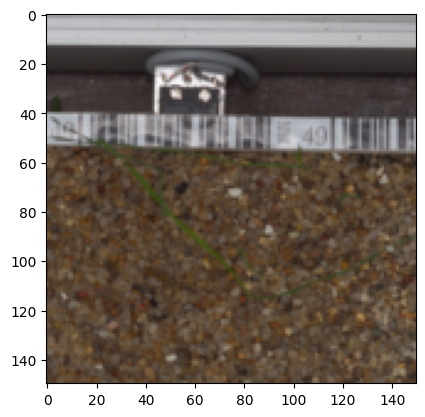

In [ ]:
def display_img(img,label):
    print(f"Label : {label}")
    plt.imshow(img.permute(1, 2, 0))

#display the first image in the dataset
display_img(*dataset[0])

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 500
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])

test_size = round(len(train_data)/5)
train_size = len(train_data)-test_size
train_data,test_data = random_split(train_data,[train_size,test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")


#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 3264
Length of Validation Data : 500


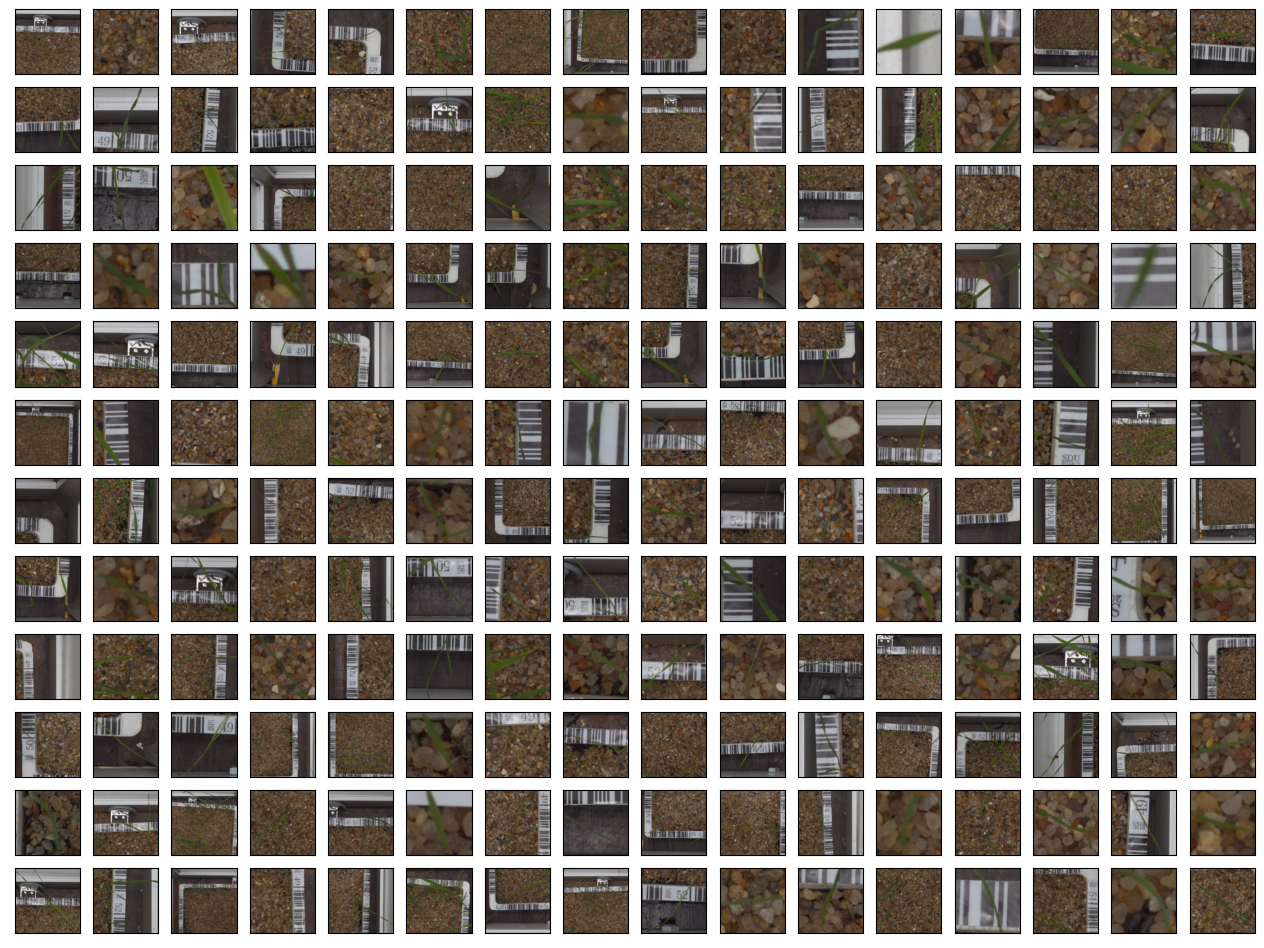

In [41]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import math

def show_batch(dataset):
    """Plot images grid of single batch"""
    fig,ax = plt.subplots(12, 16, figsize = (16,12), sharex=True, sharey=True)
    for i in range(16*12):
        ax[math.floor(i/16),i%16].imshow(dataset[i][0].permute(1, 2, 0), cmap = "Greys_r")
        ax[math.floor(i/16),i%16].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fig.show()

show_batch(dataset)

## Models definition

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images.to(device))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images.to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [43]:
class PlantClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.LazyBatchNorm2d(),
            nn.Conv2d(3, 64, kernel_size = 7, padding = 1, stride= 2),
            nn.ReLU(),
            nn.MaxPool2d(3,2),

            nn.LazyBatchNorm2d(),
            nn.Conv2d(64, 128, kernel_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3,2),

            nn.LazyBatchNorm2d(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3,2),

            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512,len(dataset.classes)),
            nn.Softmax()
        )

    def forward(self, xb):
        return self.network(xb)

In [44]:
class PlantClassificationDropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.LazyBatchNorm2d(),
            nn.Conv2d(3, 64, kernel_size = 7, padding = 1, stride= 2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(3,2),

            nn.LazyBatchNorm2d(),
            nn.Conv2d(64, 128, kernel_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(3,2),

            nn.LazyBatchNorm2d(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(3,2),


            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512,len(dataset.classes)),
            nn.Softmax()
        )
    def forward(self, xb):
        return self.network(xb)

In [45]:
import time

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        import time

        start = time.time()

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        end = time.time()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['time']=end-start
        print(result['time'])
        model.epoch_end(epoch, result)
        history.append(result)

    return history

## Models training and performance analysis

### Base model

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001#fitting the model on training data and record the result after each epoch
model = PlantClassification().to(device)
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


plot_accuracies(history)
plt.show()

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)


In [ ]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images= images.to(device)
        labels=labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001#fitting the model on training data and record the result after each epoch
modelDropout = PlantClassificationDropout().to(device)
history_dropout = fit(num_epochs, lr, modelDropout, train_dl, val_dl, opt_func)

In [ ]:
plot_accuracies(history_dropout)

plot_losses(history_dropout)

plt.show()


In [ ]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images= images.to(device)
        labels=labels.to(device)
        # calculate outputs by running images through the network
        outputs = modelDropout(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')